In [1]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F

import seaborn as sns
# sns.set()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Input image

In [2]:
from PIL import Image

basewidth = 1200
img = Image.open('./test_folder/input_image/16.jpg')    # put your image here
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('./test_folder/processed_image.jpg')

### Temp folder

In [3]:
import os
 
dir = './test_folder/fifty/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

dir = './test_folder/hundred/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

900 1200
9 12


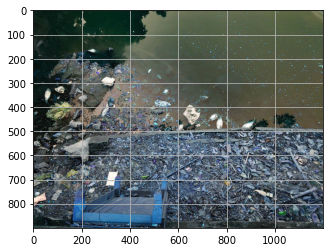

In [4]:
import numpy as np
import cv2

img = cv2.imread('./test_folder/processed_image.jpg')

resized = cv2.resize(img, (int(round(img.shape[1], -2)), int(round(img.shape[0], -2))))     # round pixel, for example: 533*808 => 500*800
plt.imshow(resized)
plt.grid(None)

height = resized.shape[0]   # 500
width = resized.shape[1]    # 800
print(height, width)

row100=0    # no. 100*100 images every row
column100=0 # no. 100*100 images every column
for x in range(0, height, 100):
    row100+=1
    for y in range(0, width, 100):
        column100+=1
        cropp = resized[x:x+100, y:y+100]
        cv2.imwrite('./test_folder/hundred/'+str(int(x/100))+str(int(y/100))+'.jpg', cropp)

column100=int(column100/row100)
print(row100, column100)


In [5]:
# setup
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### get classes

In [6]:
# get class information
data_path = './Marine_Litter_Dataset_developed_for_APLASTIC_Q_publication'
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
    ]
)
# PLD
PLD_train = datasets.ImageFolder(
    root=data_path + "/PLD_train_test/train", transform=transform
)
PLD_train_loader = torch.utils.data.DataLoader(PLD_train, batch_size=32, shuffle=True)

PLD_test = datasets.ImageFolder(
    root=data_path + "/PLD_train_test/test", transform=transforms.ToTensor()
)
PLD_test_loader = torch.utils.data.DataLoader(PLD_test, batch_size=800)

# PLQ
PLQ_train = datasets.ImageFolder(
    root=data_path + "/PLQ_train_test/train", transform=transform
)
PLQ_train_loader = torch.utils.data.DataLoader(PLQ_train, batch_size=32, shuffle=True)

PLQ_test = datasets.ImageFolder(
    root=data_path + "/PLQ_train_test/test", transform=transforms.ToTensor()
)
PLQ_test_loader = torch.utils.data.DataLoader(PLQ_test, batch_size=800)

### models

In [7]:
class APALASTIC_Q(nn.Module):
    def __init__(self, task='d'):
        super(APALASTIC_Q, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        if task=='d':
            self.fc1 = nn.Linear(30976,512)
            self.fc2 = nn.Linear(512,6)
        elif task=='q':
            self.fc1 = nn.Linear(5184,512)
            self.fc2 = nn.Linear(512,18)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p=0.25)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.dropout(x, p=0.25)
        x = x.view(-1, x.numel()//x.shape[0])
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.relu(x)
        return x

In [8]:
torch.cuda.empty_cache()

### load model

In [9]:
model = APALASTIC_Q('d')
model.load_state_dict(torch.load('./model/aippld.pth'))
model.eval()

transform=transforms.ToTensor()

### PLD

In [10]:
classification_matrix=[]

for i in range(row100):
    a=[]
    for j in range(column100):
        img=Image.open('./test_folder/hundred/'+str(i)+str(j)+'.jpg')
        x=transform(img)
        x=x.unsqueeze(0)
        pred=torch.argmax(model(x),1)
        a.append(pred.item())
    classification_matrix.append(a)

In [11]:
print(np.array(classification_matrix))
# # ['Litter - high', 'Litter - low', 'Other', 'Sand', 'Vegetation', 'Water']
# #        0                  1          2        3          4          5

[[5 1 1 5 4 4 1 4 4 4 4 1]
 [1 5 1 5 4 5 4 4 4 4 4 4]
 [1 4 1 1 1 5 5 5 4 4 4 4]
 [1 0 1 0 5 1 5 5 5 4 4 4]
 [1 0 0 1 0 1 0 1 1 0 1 0]
 [1 1 1 0 1 0 0 4 1 4 0 1]
 [1 1 1 1 4 4 1 0 4 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 4 0]
 [4 0 0 1 1 1 4 4 4 4 4 0]]


### PLQ

In [12]:
model1 = APALASTIC_Q('q')
model1.load_state_dict(torch.load('./model/aipplq.pth'))
model1.eval()

esti_area_matrix_temp=[]
for i in range(row100):
    for j in range(column100):
        if classification_matrix[i][j]==4 or classification_matrix[i][j]==5:
            esti_area_matrix_temp.append([-1,-1,-1,-1]) # if it's vegetation or water then label -1
        else:
            img=cv2.imread('./test_folder/hundred/'+str(i)+str(j)+'.jpg')   # read every 100*100 images
            a=[]
            for x in range(0, 100, 50):
                for y in range(0, 100, 50):
                    cropp = img[x:x+50, y:y+50]     # cut 100*100 images into 4 50*50 images
                    # cv2.imwrite('./test_folder/fifty/'+str(i)+str(j)+str(int(x/50))+str(int(y/50))+'.jpg', cropp) # enable this if u want
                    x_now=transform(cropp)
                    x_now=x_now.unsqueeze(0)
                    pred_now=torch.argmax(model1(x_now),1)
                    a.append(pred_now.item())
            esti_area_matrix_temp.append(a)

In [13]:
# Each matrix like [1 2 3 4] is understood as the class of 4 images cut from 100*100 images
# The step below is changing matrix like [1 2 3 4] to [[1 2],
#                                                      [3 4]]
"""
Example result:
  3  3 |  3  3 |  3 17 |  5  3 | 10  0 | 14  5 | -1 -1 | -1 -1
  3  3 |  3  5 |  0  7 |  7  0 |  0  4 | 14  5 | -1 -1 | -1 -1
 -------------------------------------------------------------
 11  5 |  5  4 | -1 -1 | -1 -1 | -1 -1 | -1 -1 | -1 -1 | 16  5
 17 17 | 17  5 | -1 -1 | -1 -1 | -1 -1 | -1 -1 | -1 -1 |  5  7
 -------------------------------------------------------------
 -1 -1 | 17 17 |  5  3 |  3  4 |  0  0 |  4  3 |  5 10 |  5  5
 -1 -1 | 17  0 |  4  5 |  5  4 |  4 17 |  4  4 |  5 10 | 14  5
 -------------------------------------------------------------
 17 17 | 17 17 | 17  4 |  5  5 | 10  4 |  4 10 |  4  5 | -1 -1
 17 17 | 17 17 | 17 17 |  3  5 |  4  5 |  4  3 |  3  3 | -1 -1
 -------------------------------------------------------------
 17 17 | 17 17 | -1 -1 |  5  4 | 17  4 | 17  3 | -1 -1 |  5 17
 17 17 | 17 17 | -1 -1 | 17 17 | 17 17 | 11 11 | -1 -1 | 17 17
"""
esti_area_matrix = []
for x in range(row100):
    aa = 0
    bb = 1
    check = False
    a = []
    y = 0
    while True:
        a.append(esti_area_matrix_temp[column100*x+y][aa])
        a.append(esti_area_matrix_temp[column100*x+y][bb])
        if y == column100-1 and check == False:
            esti_area_matrix.append(a)
            aa += 2
            bb += 2
            y = 0
            check = True
            a = []
            continue
        if y == column100-1 and check == True:
            esti_area_matrix.append(a)
            break
        y += 1
    # esti_area_matrix.append(a)
print(np.array(esti_area_matrix))
# # [0 'Cans',1 'Carton',2 'Other',3 'Plastic bag - large',4 'Plastic bag - small',5 'Plastic bottles',6 'Plastic bowls',7 'Plastic canister',
# # 8 'Plastic cups',9 'Plastic other',10 'Polystyrene packaging',11 'Sand',12 'Shoes',13 'String and cord',14 'Styrofoam',15 'Textiles',
# # 16 'Vegetation',17 'Water'] [-1: no pollution]


[[-1 -1 16 16 16  5 -1 -1 -1 -1 -1 -1 17 17 -1 -1 -1 -1 -1 -1 -1 -1 17 17]
 [-1 -1  5 16 16 16 -1 -1 -1 -1 -1 -1 17 17 -1 -1 -1 -1 -1 -1 -1 -1 17 17]
 [ 4 16 -1 -1 16 16 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4 16 -1 -1  4  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [16  3 -1 -1  4  3  2  0 17 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3  4 -1 -1 17  5  4  0 17 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [16  4  4  4  5 17  3 11 -1 -1 14 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [16  4 16  4 16 17  5  2 -1 -1  3  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 5 16 16  4 16  3  0  0  0  0  0 11  5  4 17 11 17 17 17 17 14 17 17 17]
 [16  4 16  4  4  2  0  4  4  5  4  5  4  0 17 10 17  5  4  5 16  4 17 17]
 [16  4  4  4  5  5  5  5  7  5  0  5  5  5 -1 -1  4  4 -1 -1  4  0  4  0]
 [ 4  4  3  5  5  4  4  0  0  0  0  0  7  0 -1 -1  7  3 -1 -1  4  4  7  5]
 [ 2  4  4 16  5  4  4  0 -1 -1 -1 -1  0  4  0  0 -1 -1  0  4  0  4  0  4]
 [ 4  4  4  5  5  0  5  0

In [14]:
def draw(matrixx, model_classes, cmap, more_class):
    # This just makes some sample 2D data and a corresponding vmap dict with labels for the values in the data
    data = matrixx

    vmap=more_class
    vmap.update({i: item for i, item in enumerate(model_classes)})
    
    n = len(vmap)

    #https://xkcd.com/color/rgb/
    # cmap = sns.color_palette("bright", n)
    ax = sns.heatmap(data, cmap=cmap)
    # Get the colorbar object from the Seaborn heatmap
    colorbar = ax.collections[0].colorbar
    # The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
    colorbar.set_ticklabels(list(vmap.values()))

### result

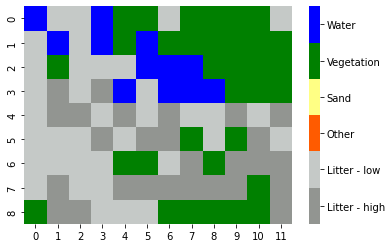

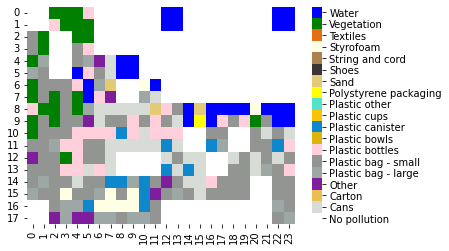

In [15]:
# define color for each class class
cmap0=['#929591', '#c5c9c7', '#ff5b00', '#ffff84', 'green', 'blue'] #pld
cmap1=['white', '#d8dcd6', '#edbc53', '#7e1e9c', '#9da8a6', '#929591', '#ffcfdc', '#dbb40c', '#0e87cc', 
'#fac205', '#54e3c9', 'yellow', '#e2ca76', '#383532', '#ad8150', '#ffffe4', '#e36e14', 'green', 'blue'] #plq

plot1 = plt.figure(1)
draw(classification_matrix, PLD_train.classes, cmap0, {})
plot2 = plt.figure(2)
draw(esti_area_matrix, PLQ_train.classes, cmap1, {-1:'No pollution'})

### Estimate

In [16]:
# "Estimate" items in each class
def count_class(classes, matrix, mult, count_pollution=True):
    vmap = {}
    if(count_pollution == True):
        vmap = {-1: 'No pollution'}
    vmap.update({i: item for i, item in enumerate(classes)})
    unique, counts = np.unique(matrix, return_counts=True)
    appear = [vmap[i] for i in unique]
    output = dict(zip(appear, np.ceil(counts*mult)))
    output.pop('Water')
    output.pop('Vegetation')
    if(count_pollution == True):
      output.pop('No pollution')
    return output

In [17]:
# PLD
count_class(PLD_train.classes, classification_matrix, 1.5, False)

{'Litter - high': 41.0, 'Litter - low': 54.0}

In [18]:
# PLQ
count_class(PLQ_train.classes, esti_area_matrix, 2.5, count_pollution=True)

{'Cans': 88.0,
 'Other': 23.0,
 'Plastic bag - large': 58.0,
 'Plastic bag - small': 200.0,
 'Plastic bottles': 73.0,
 'Plastic canister': 30.0,
 'Polystyrene packaging': 3.0,
 'Sand': 8.0,
 'Styrofoam': 23.0}